# <XGBoost 모델에 XAI 적용>
# 실습 2: 심장병 환자 진단

In [1]:
# XGBoost 라이브러리 설치
!pip install xgboost==1.7.1

데이터 구성
- age: 나이
- sex: 성별
- cp: 가슴 통증 형태
- trestbps: (안정 시 수축기) 혈압
- chol: 총 콜레스테롤
- fbs: 공복 혈당
- restecg: 안정 심전도 결과
- thalach: 최대 심박수
- exang: 운동 유발 협심증 여부
- oldpeak: 운동 대비 ST 하강 정도
- slope: 운동 중 ST 분절 기울기
- ca: 주요 혈관 수
- thal: 지중해성 빈혈 검사 결과
- target: 심장질환 유무(목표 변수)

In [2]:
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

In [3]:
# 심장병 진단 모델을 XGBoost 알고리즘을 사용해서 코드로 구현

# 데이터 불러오기
dataset = pd.read_csv('./heart.csv')

# X, y 데이터 구성
X = dataset.iloc[:, 0:13] # 총 13개의 input feature
y = dataset.iloc[:, 13] # 13번 column이 target 예측값
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)


# 모델 학습
model = XGBClassifier()
model.fit(x_train, y_train)

# 예측하기
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred] # 확률 반올림하여 예측 결과 정리

# 정확도 계산
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.13%


- stratify: y값의 label 별로 훈련, 시험 데이터 분배

In [4]:
# 학습된 모델로 특정 환자에 대한 심장병을 진단하는 코드
patient = {
    'age' : [46],
    'sex' : [0],
    'cp' : [1],
    'trestbps': [105],
    'chol': [204],
    'fbs': [0],
    'restecg': [1],
    'thalach': [172],
    'exang': [0],
    'oldpeak': [0],
    'slope': [2],
    'ca': [0],
    'thal': [2]
}

value = np.array(list(patient.values()))
value = value.T # T: Transpose (전치)
l = model.predict_proba(value)
print('No heart desease: {:.2%}\nYes heart desease: {:.2%}'.format(l[0][0], l[0][1]))

No heart desease: 0.08%
Yes heart desease: 99.92%


- 하이퍼파라미터 튜닝은 모델의 테스트 정확도를 올릴 수 있으나, 환자의 심장병 진단 이유를 설명할 수는 없음
- 머신러닝 모델에 **XAI를 결합**하면 피처와 모델에 대한 해석이 가능해짐

## 의사 결정 트리 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

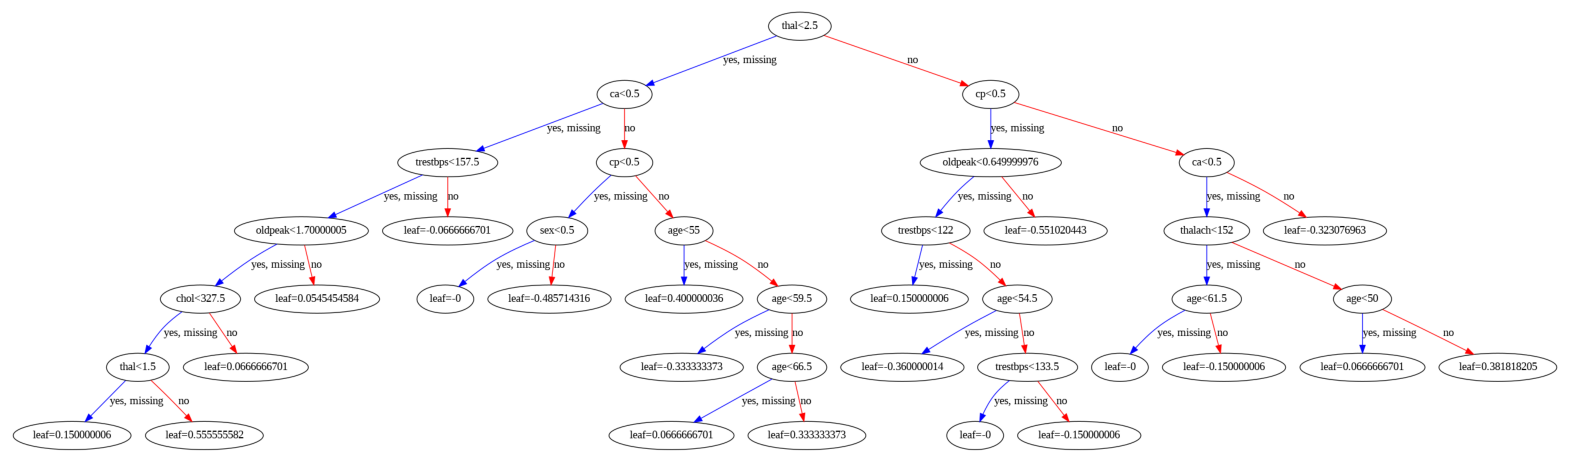

In [5]:
%matplotlib inline

from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams # rcParams: matplotlib 차트의 시각화 옵션 설정 라이브러리

rcParams['figure.figsize'] = 20, 50

plot_tree(model)
plt.show

- 환자의 정보에 따라 의사결정트리를 진행하여 나온 리프노드의 값을 로지스틱 함수에 넣으면 심장병일 확률이 계산된다.

- 이진 로지스틱 함수의 결과가 0.5를 넘으면 심장병, 0.5 미만이면 심장병 아님

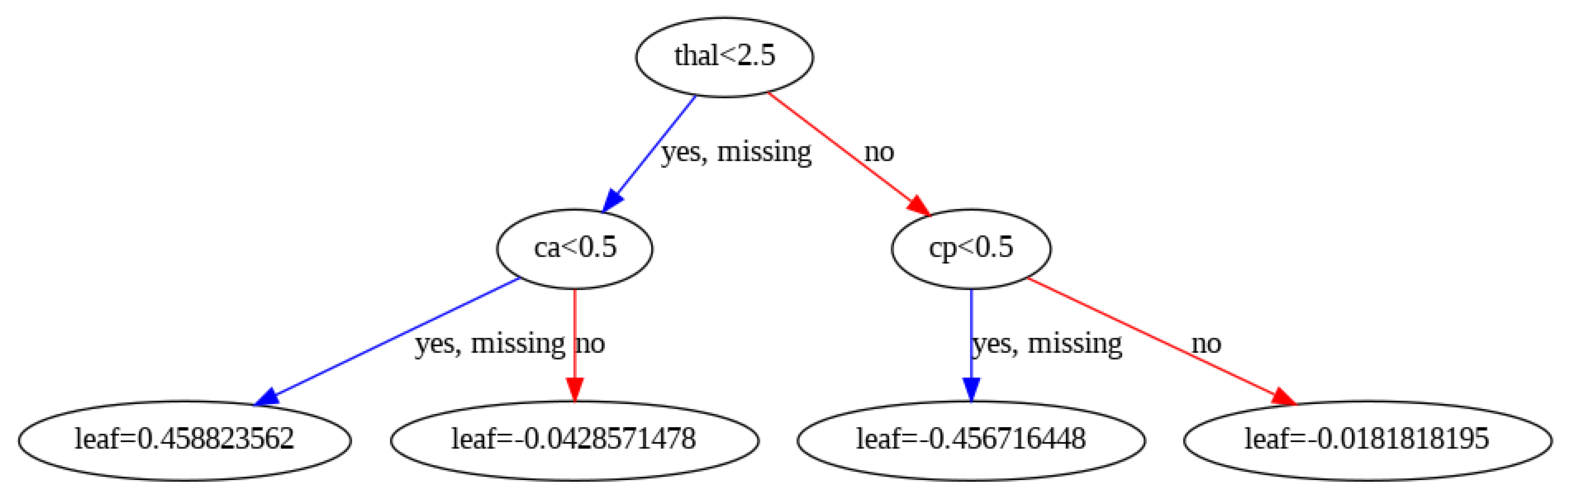

In [6]:
# XGBClassifier의 max_depth 옵션을 조절해 의사 결정 트리의 깊이를 변경

model = XGBClassifier(max_depth=2)
model.fit(x_train, y_train)

plot_tree(model)
plt.show()

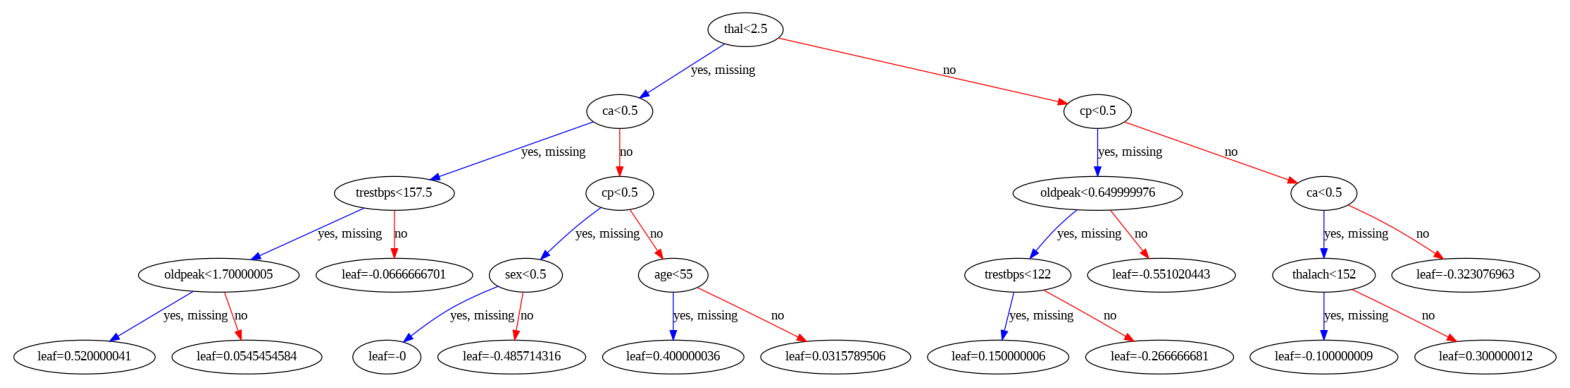

In [7]:
# max_depth = 4로 변경
model = XGBClassifier(max_depth=4)
model.fit(x_train, y_train)

plot_tree(model)
plt.show()

의사 결정 트리 시각화를 통해
- 모델이 어떤 비중으로 특정 피처를 우선순위로 생각하는지,
- 단계마다 어떤 기준으로 심장병을 진단하는지

알아볼 수 있다.

## 피처 중요도
- 피처 중요도: 해당 피처가 모델의 에러를 얼마나 줄여주는지를 근거로 중요성을 측정하는 방법
- 특정 피처마다 한번씩 순회하면서 모델을 만들고 에러를 측정하며 FI를 조정
- **피처 중요도는 피처 간 의존성이 낮은 상태에서 정확한 분석이 될 확률이 높다.**

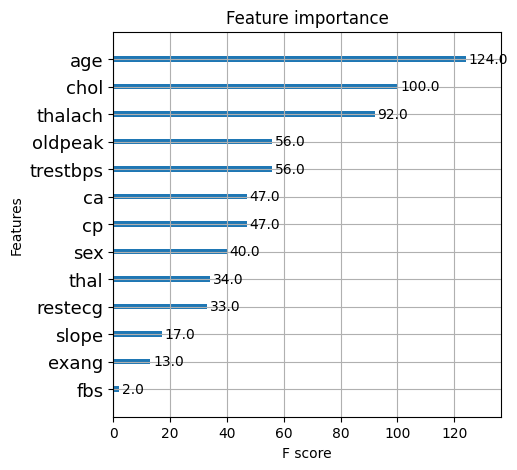

In [8]:
# 심장병 진단 모델의 피처 중요도를 계산

from xgboost import plot_importance # plot_importance을 통해 학습된 모델을 이용하여 각 피처의 중요도를 계산

rcParams['figure.figsize'] = 5, 5

plot_importance(model)

plt.yticks(fontsize=13)
plt.show()

피처 중에서 나이와 콜레스테롤이 상당히 높은 영향도를 가지고 있음을 확인할 수 있다.

- 의사결정트리에서는 thal가 루트 노드에 위치(가장 중요한 정보)
- 피처 중요도: age가 가장 중요

=> 의사 결정 트리와 피처 중요도의 순서는 일치할 수도 있으나, 차이가 있을 수 있음 (계산 방식의 차이로 인해)

**계산 방법**
- 의사 결정 트리: 정보 이득이 큰 방향으로 노드의 선정과 분기 기준이 결정
- 피처 중요도: 모델의 에러에 큰 영향을 미치는 정도로 정렬

**해석 방법**
- 의사 결정 트리: 심장병을 진단하는 우선 순위
- 피처 중요도: 심장병 진단에 영향을 미치는 정도



## 부분 의존성 플롯

**피처 중요도의 한계**
- 피처 중요도는 피처가 결과에 미치는 영향을 절대값으로 알 수 있음 (=어느 방향으로 영향을 미치는지 알 수 없음)
- 피처 간에 독립된 상황에서 분석 정확도가 높음 (실제 많은 데이터가 피처 간 상관 관계가 조금씩은 있음)

**부분 의존성 플롯의 특징**
- 피처의 수치에 따라 모델에 기여하는 정도가 어떻게 변화하는지 볼 수 있음
- 피처가 모델에 어떤 방향으로 영향을 미치는지 파악할 수 있음
- 피처 간 독립이 안되는 상황에서 모델 분석이 가능함

## 부분 의존성 플롯 그리기
- pdpbox 라이브러리 사용

In [9]:
# pdpbox 라이브러리 설치
# pdp 라이브러리: 부분 의존성 플롯을 그리는 툴박스
!pip install pdpbox

In [10]:
# colab matplotlib 폰트 경고 메시지 제거
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.CRITICAL)

In [28]:
# age 피처에 대한 target_plot 그리기
from pdpbox import pdp, info_plots

heart_data = dataset
heart_features = dataset.columns[0:13] # 데이터의 input feature
heart_target = dataset.columns[13] # 데이터의 label

info_plots.TargetPlot(df=heart_data, feature='age', feature_name='age', target=heart_target)

# plt.show()

**target plot**
- 학습 모델이 아닌, **학습 데이터**를 분석하는 방법
- 가정: 학습 데이터를 분석하면 학습 모델의 내부 거동을 파악할 수 있다
- 근거: 모델은 학습 데이터를 이용하여 만들어지므로

## 예측 분포 플롯 (prediction distribution plot)
모델까지 함께 분석해보자.